In [1]:
## Include packages

using DelimitedFiles
using DCAUtils
using Plots
using KitMSA
using FastaIO
using Statistics
using StatsBase
using LinearAlgebra
using CSV, DataFrames

include("../src/read_write.jl")
include("../src/energy.jl")
include("../src/msa_tools.jl")
include("../src/extra_tools.jl")
;

[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]
[ Info: Precompiling KitMSA [e1e610c1-b74d-45c6-9a0f-61473e47a018]


In [2]:

function nanmean(arr)
    x = filter(!isnan, arr)
    return mean(x)
end

function nanmeanquadrat(arr)
    x = filter(!isnan, arr)
    return sqrt(sum(x .^2)/ length(x))
end

function nanstd(arr)
    x = filter(!isnan, arr)
    return std(x)
end

function nanmean(arr, dims)
    if dims == 1
        return [nanmean(arr[i, :]) for i in 1:size(arr, 2)]
    elseif dims == 2
        return [nanmean(arr[i, :]) for i in 1:size(arr, 1)]
    else
        println("dims $(dims) non supported")
        return 0
    end
end

function nanmeanquadrat(arr,dims)
    if dims == 1
        return [nanmeanquadrat(arr[i, :]) for i in 1:size(arr, 2)]
    elseif dims == 2
        return [nanmean(arr[i, :]) for i in 1:size(arr, 1)]
    else
        println("dims $(dims) non supported")
        return 0
    end
end

function nanstd(arr, dims)
    if dims == 1
        return [nanstd(arr[i, :]) for i in 1:size(arr, 2)]
    elseif dims == 2
        return [nanstd(arr[i, :]) for i in 1:size(arr, 1)]
    else
        println("dims $(dims) non supported")
        return 0
    end
end

nanstd (generic function with 2 methods)

In [3]:
PATH_PAR_dbd = "../data/model_parameters/Parameters_conv_Thr-PCD40.dat"
htmp, Jtmp = KitMSA.read_par_BM(PATH_PAR_dbd)
h = KitMSA.set_max_field_to_0(htmp)
J = KitMSA.symmetrize_J(Jtmp)
maximum(J)

1.959042

In [4]:
path_dbd = "../data/alignments/natural/DBD_alignment.uniref90.cov80.a2m"
nat_dbd = Int8.(fasta2matrix(path_dbd))
;

In [5]:
function extract_1wt(input_df, prot)
    wt = []
    df = input_df[input_df[:, "PROT"] .== prot,:]
    site_vec = df.SITE
    l = length(site_vec)
    for (i, s) in enumerate(site_vec[1:(l - 1)])
        if site_vec[i+1] != site_vec[i] || i == (l - 1)
            append!(wt, df.WTAA[i])
        end
    end
    res = []
    for i in 1:length(wt)
        push!(res, Int8.(letter2num(wt[i])))
    end
    return res
end

function find_conting_pos(seqs)
    num_seqs, seq_length = size(seqs)
    res = []
    # Iterate over each seqeunce and each position
    for n in 2:num_seqs
        different_positions = []
        for i in 1:seq_length
            ref_aa = seqs[n, i]

            # Check if the amino is different from all previous aminos
            is_different = all(ref_aa .!= seqs[1:n-1, i])

            if is_different
                push!(different_positions, i)
            end
        end
        push!(res, Int8.(different_positions))
    end

    return res
end

function find_entren_pos(seqs)
    num_seqs, seq_length = size(seqs)
    res = []
    # Iterate over each seqeunce and each position
    for n in 1:num_seqs-1
        different_positions = []
        for i in 2:seq_length
            ref_aa = seqs[n, i]

            # Check if the amino is different from all previous aminos
            is_different = all(ref_aa .!= seqs[n+1:num_seqs, i])

            if is_different
                push!(different_positions, i)
            end
        end
        push!(res, Int8.(different_positions))
    end

    return res
end

function check_one_mut_effect(seq, site, aa, h, J)
    sseq = deepcopy(seq)
    sseq[site] = aa
    return delta_energy(h, J, sseq, seq)
end


check_one_mut_effect (generic function with 1 method)

In [33]:
function contingency(df, wt_list, max_ham)
    
    wts = Int8.(hcat([extract_1wt(df, prot) for prot in wt_list]...)')
    mut_idxs = find_conting_pos(wts)

    ddE = Vector{Vector{Float64}}(undef, 100)
    for i in 1:100
        ddE[i] = Vector{Float64}[]
    end
    
    for i in 2:size(wts)[1]
    #for i in size(wts)[1]:size(wts)[1]
        for j in 1:i-1
      
            ref_wt = wts[i,:]
            past_wt = wts[j,:]
            ref_ind = wt_list[i]
            past_ind = wt_list[j]
            past_dms = df[  df[:, "PROT"] .== past_ind, :]
            ref_dms = df[  df[:, "PROT"] .== ref_ind, :]
            ref_mut = mut_idxs[i-1]
            
            orig_aa = [num2letter(a) for a in ref_wt[ref_mut]]
            new_aa = [num2letter(a) for a in past_wt[ref_mut]]
             
            fit = [past_dms[(past_dms[:,"SITE"] .== ref_mut[i]) .& 
                (past_dms[:,"MTAA"] .== orig_aa[i]),:].FIT[1] 
                for i in 1:length(orig_aa)]
        
            fit0 = [ref_dms[(ref_dms[:,"SITE"] .== ref_mut[i]) .& 
                (ref_dms[:,"MTAA"] .== new_aa[i]),:].FIT[1] 
                for i in 1:length(new_aa)]
            #dict = get_dictF(j, wt_list, df)
            #dict0 = get_dictF(i, wt_list, df)
            d = Int(KitMSA.my_hamming(ref_wt, past_wt))
            fit_diff = fit .+ fit0
            #fit_diff = [map_dict(fit[i], dict) - map_dict(-fit0[i], dict0)
             #   for i in 1:length(fit)]
            push!(ddE[d], fit_diff...)
        end
    end
    println("Cont")
    println([length(x) for x in ddE[1:max_ham]])
    return ddE, [mean(x) for x in ddE][1:max_ham], [std(x) for x in ddE][1:max_ham] 
end


function entrenchment(df, wt_list, max_ham)
    ##Entrenchement
    #select aminos that are in a wt and not after, check their mut effect after
    wts = Int8.(hcat([extract_1wt(df, prot) for prot in wt_list]...)')
    mut_idxs = find_entren_pos(wts)
    
    ddE = Vector{Vector{Float64}}(undef, 100)
    for i in 1:100
        ddE[i] = Vector{Float64}[]
    end
    
    for i in 1:size(wts)[1]-1
    #for i in 1:1
        for j in i+1:size(wts)[1]
            
            ref_wt = wts[i,:]
            past_wt = wts[j,:]     
            ref_ind = wt_list[i]
            past_ind = wt_list[j]
            past_dms = df[  df[:, "PROT"] .== past_ind, :]
            ref_dms = df[  df[:, "PROT"] .== ref_ind, :]
            ref_mut = mut_idxs[i]

            orig_aa = [num2letter(a) for a in ref_wt[ref_mut]]
            new_aa = [num2letter(a) for a in past_wt[ref_mut]]
            
            fit = [past_dms[(past_dms[:,"SITE"] .== ref_mut[i]) .& 
                (past_dms[:,"MTAA"] .== orig_aa[i]),:].FIT[1] 
                for i in 1:length(orig_aa)]
            
            fit0 = [ref_dms[(ref_dms[:,"SITE"] .== ref_mut[i]) .& 
                (ref_dms[:,"MTAA"] .== new_aa[i]),:].FIT[1] 
                for i in 1:length(new_aa)]
            #dict = get_dictF(j, wt_list, df)
            #dict0 = get_dictF(i, wt_list, df)
            d = Int(KitMSA.my_hamming(ref_wt, past_wt))
            fit_diff = fit .+ fit0
            #fit_diff = [map_dict(fit[i], dict) - map_dict(-fit0[i], dict0)
             #   for i in 1:length(fit)]
            push!(ddE[d], fit_diff...)
        end
    end
    println("Entr")
    println([length(x) for x in ddE[1:max_ham]])
    return ddE, [mean(x) for x in ddE][1:max_ham], [std(x) for x in ddE][1:max_ham] 
end

function contingency_DCA(wts, wt_list, df, mut_idxs, max_ham)
    ##Entrenchement
    #select aminos that are in a wt and not before, check their mut effect before
    ddE = Vector{Vector{Float64}}(undef, 100)
    for i in 1:100
        ddE[i] = Vector{Float64}[]
    end
    
    for i in 2:size(wts)[1]
    #for i in size(wts)[1]:size(wts)[1]
        for j in 1:i-1
      
            ref_wt = wts[i,:]
            past_wt = wts[j,:]
            ref_mut = mut_idxs[i-1]
            
            orig_aa = ref_wt[ref_mut]
            new_aa = past_wt[ref_mut]
            
            if length(orig_aa) != 0
        
                en = [check_one_mut_effect(past_wt, ref_mut[l], orig_aa[l], h, J)  
                    for l in 1:length(orig_aa)]
        
                en0 = [check_one_mut_effect(ref_wt, ref_mut[l], new_aa[l], h, J)  
                    for l in 1:length(new_aa)]
                #dict = get_dictE(j, wts, h, J)
                #dict0 = get_dictE(i, wts, h, J)
                dict = tot_E2F
                dict0 = dict
                d = Int(KitMSA.my_hamming(ref_wt, past_wt))
                #en_diff = en .+ en0
                en_diff = [map_dict(en[i], dict) - map_dict(-en0[i], dict0) 
                  for i in 1:length(en)]
                #en_diff = [map_dict(en[i], dict) - map_dict(-en0[i], dict0)
                 #  for i in 1:length(en)]
                push!(ddE[d], en_diff...)
            end
        end
    end
    return ddE, [mean(x) for x in ddE][1:max_ham], [std(x) for x in ddE][1:max_ham]
end

function entrenchment_DCA(wts, wt_list, df, mut_idxs, max_ham)
    ##Entrenchement
    #select aminos that are in a wt and not after, check their mut effect after
    ddE = Vector{Vector{Float64}}(undef, 100)
    for i in 1:100
        ddE[i] = Vector{Float64}[]
    end
    
    for i in 1:size(wts)[1]-1
    #for i in 1:1
        for j in i+1:size(wts)[1]
           
            ref_wt = wts[i,:]
            past_wt = wts[j,:]
            ref_mut = mut_idxs[i]
            
            orig_aa = ref_wt[ref_mut]
            new_aa = past_wt[ref_mut]
            
            if length(orig_aa) != 0
        
                en = [check_one_mut_effect(past_wt, ref_mut[l], orig_aa[l], h, J)  
                    for l in 1:length(orig_aa)]
        
                en0 = [check_one_mut_effect(ref_wt, ref_mut[l], new_aa[l], h, J)  
                    for l in 1:length(new_aa)]
                #dict = get_dictE(j, wts, h, J)
                #dict0 = get_dictE(i, wts, h, J)
                dict = tot_E2F
                dict0 = dict
                d = Int(KitMSA.my_hamming(ref_wt, past_wt))
                #en_diff = en .+ en0
                en_diff = [map_dict(en[i], dict) - map_dict(-en0[i], dict0) 
                  for i in 1:length(en)]
                push!(ddE[d], en_diff...)
            end
        end
    end
    return ddE, [mean(x) for x in ddE][1:max_ham], [std(x) for x in ddE][1:max_ham]
end

function contingency_DCA!(ddE, wts, wt_list, df,mut_idxs)
    ##Entrenchement
    #select aminos that are in a wt and not before, check their mut effect before
    for i in 2:size(wts)[1]
    #for i in size(wts)[1]:size(wts)[1]
        for j in 1:i-1
      
            ref_wt = wts[i,:]
            past_wt = wts[j,:]
            ref_mut = mut_idxs[i-1]
            
            orig_aa = ref_wt[ref_mut]
            new_aa = past_wt[ref_mut]
            
            if length(orig_aa) != 0
        
                en = [check_one_mut_effect(past_wt, ref_mut[l], orig_aa[l], h, J)  
                    for l in 1:length(orig_aa)]
        
                en0 = [check_one_mut_effect(ref_wt, ref_mut[l], new_aa[l], h, J)  
                    for l in 1:length(new_aa)]
                #dict = get_dictE(j, wts, h, J)
                #dict0 = get_dictE(i, wts, h, J)
                dict = tot_E2F
                dict0 = dict
                d = Int(KitMSA.my_hamming(ref_wt, past_wt))
                #en_diff = en .+ en0
                #en_diff = sigmoid(en,p) .+ sigmoid(en0, p)
                en_diff = [map_dict(en[i], dict) - map_dict(-en0[i], dict0) 
                  for i in 1:length(en)]
                push!(ddE[d], en_diff...)
            end
        end
    end
end

function entrenchment_DCA!(ddE, wts, wt_list, df, mut_idxs)
    ##Entrenchement
    #select aminos that are in a wt and not after, check their mut effect after
    for i in 1:size(wts)[1]-1
    #for i in 1:1
        for j in i+1:size(wts)[1]
           
            ref_wt = wts[i,:]
            past_wt = wts[j,:]
            ref_mut = mut_idxs[i]
            
            orig_aa = ref_wt[ref_mut]
            new_aa = past_wt[ref_mut]
            
            if length(orig_aa) != 0
        
                en = [check_one_mut_effect(past_wt, ref_mut[l], orig_aa[l], h, J)  
                    for l in 1:length(orig_aa)]
        
                en0 = [check_one_mut_effect(ref_wt, ref_mut[l], new_aa[l], h, J)  
                    for l in 1:length(new_aa)]
                #dict = get_dictE(j, wts, h, J)
                #dict0 = get_dictE(i, wts, h, J)
                dict = tot_E2F
                dict0 = dict
                d = Int(KitMSA.my_hamming(ref_wt, past_wt))
                #en_diff = en .+ en0
                en_diff = [map_dict(en[i], dict) - map_dict(-en0[i], dict0) 
                  for i in 1:length(en)]
                push!(ddE[d], en_diff...)                
            end
        end
    end
end

entrenchment_DCA! (generic function with 1 method)

In [7]:
# Read the CSV file into a DataFrame
df = CSV.read("../data/alignments/refs/Thornton.csv", DataFrame)
L = -2.1482 # lower bound of measurement
R =  1.6081 # dynamic range of measurement
U = L + R # upper bound of measurement
WT_ACTIVITY = -0.79 # standard WT activity
LB = L - WT_ACTIVITY + 0.05
UB = U - WT_ACTIVITY - 0.05

df[:,5] = df[:,5] .- WT_ACTIVITY
sel_wt_MAP_1 =    [1,    10,    19, 6, 7, 8, 12] # maximum a posteriori reconstructed wt
sel_wt_MAP_2 =    [1, 10,    4, 14]
;

In [11]:
l2n = [num2letter(i) for i in 1:20]
wts1 = Int8.(hcat([extract_1wt(df, prot) for prot in sel_wt_MAP_1]...)')

N_wt = length(sel_wt_MAP_1)
exp_dms = []
dca_dms = []
for i in 1:N_wt
    wt_ind = sel_wt_MAP_1[i]
    dms = df[  df[:, "PROT"] .== wt_ind, :]
    N_mut = length(dms[:,1])
    dEs = zeros(N_mut)
    for n in 1:N_mut
        aa = Int8(findfirst(x -> x == dms.MTAA[n], l2n))
        dEs[n] = check_one_mut_effect(wts1[i,:], dms.SITE[n], aa, h, J) 
    end
    #println(corspearman(dEs, dms.FIT))
    #a = scatter(dEs, dms.FIT)
    #display(a)
    push!(exp_dms, dms.FIT...)
    push!(dca_dms, dEs...)
end

mask = dca_dms .!= 0
exp_dms = exp_dms[mask]
dca_dms = dca_dms[mask]
sort_exp = exp_dms[sortperm(exp_dms, rev = true)]
sort_dca = dca_dms[sortperm(dca_dms, rev = false)]
tot_E2F = Dict([sort_dca[i]=>sort_exp[i] for i in 1:length(sort_dca)])
;



In [44]:
scatter(dca_dms, exp_dms)
cor(exp_dms, dca_dms)

-0.6456768453666736

In [12]:
function get_dictF(wt_idx, wt_list, df)
    wt_ind = wt_list[wt_idx]
    dms = df[  df[:, "PROT"] .== wt_ind, :]
    exp_dms = dms.FIT
    sort_exp = exp_dms[sortperm(exp_dms, rev = true)]
    norm_exp = reverse([i / length(sort_exp) for i in 1:length(sort_exp)])
    #a = plot(sort_exp, norm_exp)
    #display(a)
    return Dict([sort_exp[i] => norm_exp[i] for i in 1:length(sort_exp)])
end
       
function get_dictE(wt_idx, wts, h, J)
    wt = wts[wt_idx,:]
    L = length(wt)
    
    dEs = []
    for i in 1:length(wt)
        for aa in 1:20
            if aa != wt[i]
                push!(dEs, check_one_mut_effect(wt, i, aa, h, J))
            end
        end
    end
    dca_dms = dEs
    sort_dca = dca_dms[sortperm(dca_dms, rev = false)]
    norm_dca = reverse([i / length(sort_dca) for i in 1:length(sort_dca)])
    #a = plot(sort_dca, norm_dca)
    #display(a)
    return Dict([sort_dca[i] => norm_dca[i] for i in 1:length(sort_dca)])      
end

function get_dictE2F(wt_idx, wts, wt_list, df, h, J)
    l2n = [num2letter(i) for i in 1:20]
    wt_ind = wt_list[wt_idx]
    dms = df[  df[:, "PROT"] .== wt_ind, :]
    N_mut = length(dms[:,1])
    dEs = zeros(N_mut)
    for n in 1:N_mut
        aa = Int8(findfirst(x -> x == dms.MTAA[n], l2n))
        dEs[n] = check_one_mut_effect(wts[wt_idx,:], dms.SITE[n], aa, h, J) 
    end
    exp_dms = dms.FIT
    dca_dms = dEs
    sort_exp = exp_dms[sortperm(exp_dms, rev = true)]
    sort_dca = dca_dms[sortperm(dca_dms, rev = false)]
    
    return Dict([sort_dca[i] => sort_exp[i] for i in 1:length(sort_dca)])
end

function map_dict(input, dict)
    keys_array = collect(keys(dict))
    
    # Find the key with the minimum absolute difference
    closest_key = keys_array[argmin(abs.(input .- collect(keys(dict))))]

    # Assign the value corresponding to the closest key
    result_value = dict[closest_key]

    return result_value 
end

map_dict (generic function with 1 method)

In [13]:
folder_path = "../data/chains/first_fixed_amino_mixed_thornton_steps1500_seqs10000_T1.0p0.0/"

#folder_path = "../data_matteo/data/chains/new_fixed_amino_mixed_thornton_steps1500_seqs10000_T1.0p0.0/"
fasta_files = filter(file -> endswith(file, ".mixedDNA"), readdir(folder_path))
@time matrices = [Int8.(fasta2matrix(joinpath(folder_path, file))) 
    for file in fasta_files]
mask =[size(matrices[i])[1] for i in 1:size(matrices)[1]] .> 29
filt_matr = matrices[mask]
;

 22.418245 seconds (562.86 k allocations: 77.724 MiB, 0.08% gc time, 0.33% compilation time)


In [34]:
max_ham = 30
#C+E fitness and data from experiment
@time ddE_C1, m_C1, st_C1 = contingency(df, sel_wt_MAP_1, max_ham)
@time ddE_E1, m_E1, st_E1 = entrenchment(df, sel_wt_MAP_1, max_ham)

#C+E fitness from the potts model and data from experiment
wts1 = Int8.(hcat([extract_1wt(df, prot) for prot in sel_wt_MAP_1]...)')
mut_idxs1 = find_conting_pos(wts1)

@time ddE_C1_DCA, m_C1_DCA, st_C1_DCA = contingency_DCA(wts1, sel_wt_MAP_1, df, mut_idxs1, max_ham)

mut_idxs1 = find_entren_pos(wts1)

@time ddE_E1_DCA, m_E1_DCA, st_E1_DCA = entrenchment_DCA(wts1, sel_wt_MAP_1, df, mut_idxs1, max_ham)

x_DCA = 1:max_ham
x = 1:max_ham
L = 76 / 100
;

Cont
[0, 2, 0, 0, 5, 0, 14, 8, 9, 0, 11, 5, 7, 14, 0, 0, 0, 20, 0, 7, 2, 5, 7, 0, 0, 0, 5, 0, 0, 0]
  0.259078 seconds (376.50 k allocations: 38.770 MiB, 94.84% compilation time)
Entr
[0, 2, 0, 0, 5, 0, 14, 8, 9, 0, 11, 7, 8, 17, 0, 0, 0, 26, 0, 11, 11, 8, 11, 0, 0, 0, 11, 0, 0, 0]
  0.276805 seconds (379.24 k allocations: 40.523 MiB, 7.39% gc time, 94.17% compilation time)
  0.258630 seconds (204.36 k allocations: 69.980 MiB, 6.42% gc time, 74.15% compilation time)
  0.242613 seconds (205.30 k allocations: 87.795 MiB, 4.22% gc time, 68.14% compilation time)


In [15]:
ham_dists = 1:2:max_ham
n_chains = 100#length(filt_matr)
dde = Vector{Vector{Float64}}(undef, 100)
dde2 = Vector{Vector{Float64}}(undef, 100)

for i in 1:100
    dde[i] = Vector{Float64}[]
    dde2[i] = Vector{Float64}[]
end


start = time()
for i in 1:n_chains 
    println(i)
    wts_sil = filt_matr[i][ham_dists,:]
    
    mut_idxs_sil = find_conting_pos(wts_sil)
    contingency_DCA!(dde, wts_sil, sel_wt_MAP_1, df, mut_idxs_sil)
    
    mut_idxs_sil = find_entren_pos(wts_sil)
    entrenchment_DCA!(dde2, wts_sil, sel_wt_MAP_1, df, mut_idxs_sil)
end    
fine = time()
println(fine-start)


m_Csil_DCA = [mean(x) for x in dde][1:max_ham]
st_Csil_DCA = [std(x) for x in dde][1:max_ham]
m_Esil_DCA = [mean(x) for x in dde2][1:max_ham]
st_Esil_DCA = [std(x) for x in dde2][1:max_ham]

d_Csil = 1:length(m_Csil_DCA)
d_Esil = 1:length(m_Esil_DCA)
;

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
36.789642095565796


-0.036835955998910735


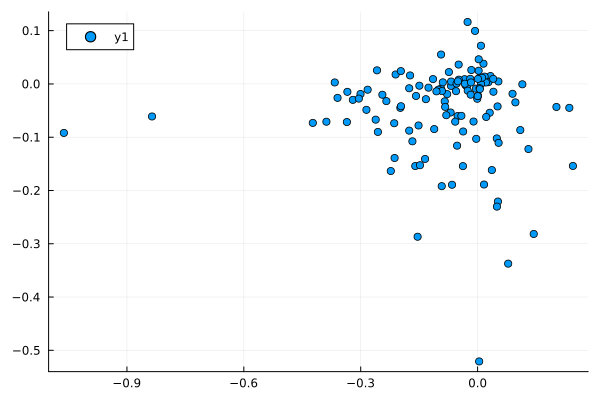

In [39]:
println(cor(vcat(ddE_C1...), vcat(ddE_C1_DCA...)))
scatter(vcat(ddE_C1...), vcat(ddE_C1_DCA...))

0.17793355529122282


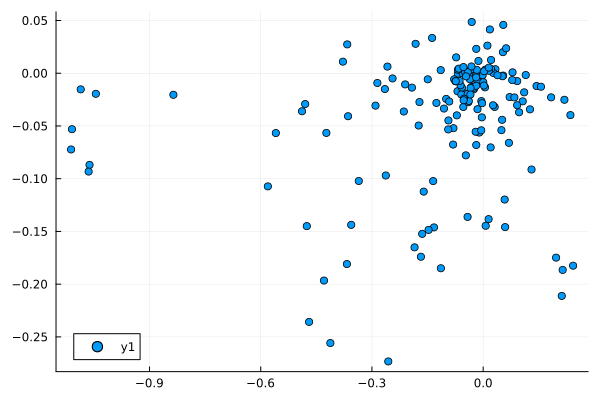

In [40]:
println(cor(vcat(ddE_E1...), vcat(ddE_E1_DCA...)))
scatter(vcat(ddE_E1...), vcat(ddE_E1_DCA...))

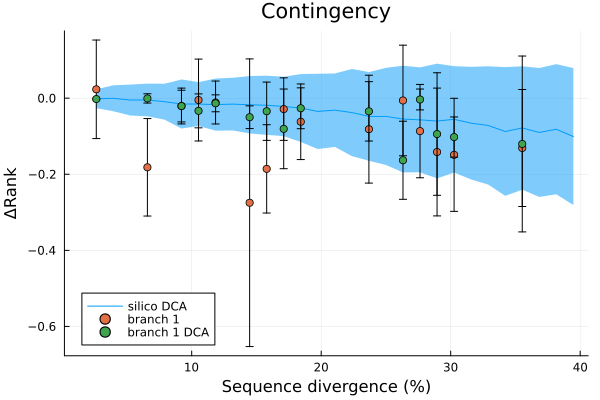

In [16]:
plot(x_DCA./L, m_Csil_DCA, ribbon = st_Csil_DCA, label = "silico DCA", 
   title = "Contingency", xlabel = "Sequence divergence (%)", ylabel = "ΔRank")
scatter!(x./L, m_C1, yerr = st_C1, label = "branch 1")
scatter!(x_DCA./L, m_C1_DCA, yerr = st_C1_DCA, label = "branch 1 DCA")
#savefig("../thornton_conting_single_dms_rank.png")
#savefig("../thornton_conting_single_dms_ddF.png")

In [23]:
length(vcat(dde2...))*2

58786

In [24]:
length(vcat(dde...))

54683

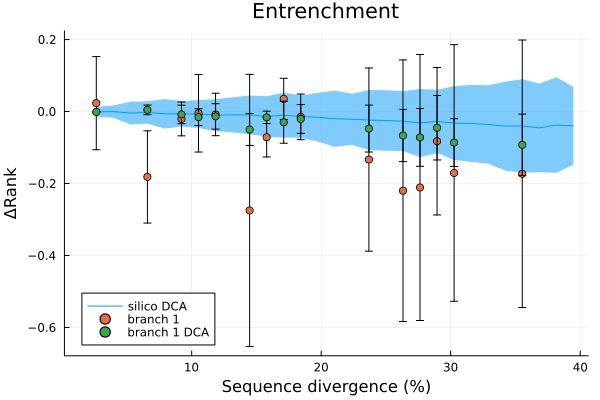

In [17]:
plot(x_DCA./L, m_Esil_DCA, ribbon = st_Esil_DCA, label = "silico DCA", 
   title = "Entrenchment", xlabel = "Sequence divergence (%)", ylabel = "ΔRank")
scatter!(x./L, m_E1, yerr = st_E1, label = "branch 1")
scatter!(x_DCA./L, m_E1_DCA, yerr = st_E1_DCA, label = "branch 1 DCA")
#savefig("../thornton_entren_single_dms_rank.png")
#savefig("../thornton_entren_single_dms_ddF.png")

In [31]:
writedlm("../data/figures/data_fig4/x_DCA", x_DCA)
writedlm("../data/figures/data_fig4/x_exp", x)
writedlm("../data/figures/data_fig4/m_Csil_DCA", m_Csil_DCA)
writedlm("../data/figures/data_fig4/m_C1", m_C1)
writedlm("../data/figures/data_fig4/m_C1_DCA", m_C1_DCA)
writedlm("../data/figures/data_fig4/m_Esil_DCA", m_Esil_DCA)
writedlm("../data/figures/data_fig4/m_E1", m_E1)
writedlm("../data/figures/data_fig4/m_E1_DCA", m_E1_DCA)

writedlm("../data/figures/data_fig4/st_Csil_DCA", st_Csil_DCA)
writedlm("../data/figures/data_fig4/st_C1", st_C1)
writedlm("../data/figures/data_fig4/st_C1_DCA", st_C1_DCA)
writedlm("../data/figures/data_fig4/st_Esil_DCA", st_Esil_DCA)
writedlm("../data/figures/data_fig4/st_E1", st_E1)
writedlm("../data/figures/data_fig4/st_E1_DCA", st_E1_DCA)

In [32]:
writedlm("../data/figures/data_fig4/dca_scores", sort_dca)
writedlm("../data/figures/data_fig4/exp_fitness", sort_exp)

## Check energy of thornton wts with our energy

In [54]:
dbd_en = energy(h, J, nat_dbd)
;

In [32]:
folder_path = "../data/src/new_fixed_amino_mixed_thornton_steps1500_seqs10000_T1.0p0.0/"

#folder_path = "../data_matteo/src/first_fixed_amino_mixed_thornton_steps1500_seqs10000_T1.0p0.0/"
fasta_files = filter(file -> endswith(file, ".mixedDNA"), readdir(folder_path))
@time matrices = [Int8.(fasta2matrix(joinpath(folder_path, file))) 
    for file in fasta_files]
mask =[size(matrices[i])[1] for i in 1:size(matrices)[1]] .> 29
filt_matr2 = matrices[mask]
;

 19.530976 seconds (2.12 M allocations: 380.838 MiB, 2.13% gc time, 1.46% compilation time)


In [51]:
m_sil_en = mean(hcat([energy(h, J, filt_matr[i][1:30,:]) 
            for i in 1:length(filt_matr)]...), dims = 2)[:]
m_sil_en2 = mean(hcat([energy(h, J, filt_matr2[i][1:30,:]) 
            for i in 1:length(filt_matr2)]...), dims = 2)[:]
st_sil_en = std(hcat([energy(h, J, filt_matr[i][1:30,:]) 
            for i in 1:length(filt_matr)]...), dims = 2)[:]
st_sil_en2 = std(hcat([energy(h, J, filt_matr2[i][1:30,:]) 
            for i in 1:length(filt_matr2)]...), dims = 2)[:]
en_thor = KitMSA.energy(h, J, wts1)
d_thor = count_muts_msa(wts1, wts1[1,:]) 
d_1 = count_muts_msa(filt_matr[1][2:end,:], wts1[1,:])
d_2 = count_muts_msa(filt_matr[2][2:end,:], wts1[1,:])
;

In [53]:
plot(d_1 ./L, m_sil_en, ribbon = st_sil_en, xlabel = "Sequence divergence (%)",
    ylabel = "Energy", label = "take first DCA")
plot!(d_2 ./L, m_sil_en2, ribbon = st_sil_en2,label = "sample DCA")
scatter!(d_thor ./L, en_thor, label = "thornton ASR")
#savefig("../thornton_energy_ASR.png")

"/home/leonardo/Documents/thornton_energy_ASR.png"

In [80]:
d_leaf = count_muts_msa(nat_dbd, wts1[end,:])
m_loc_leaf = [mean(energy(h, J, nat_dbd[d_leaf.<d, :])) for d in d_thor[2:end]]
st_loc_leaf = [std(energy(h, J, nat_dbd[d_leaf.<d, :])) for d in d_thor[2:end]]
en_loc_leaf = [(energy(h, J, nat_dbd[d_leaf.<d, :])) for d in d_thor[2:end]]
;

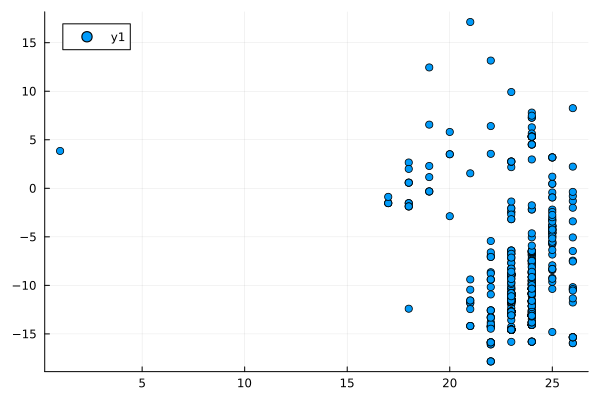

In [88]:
scatter(d_leaf[d_leaf.<d_thor[end]], en_loc_leaf[end])
#scatter!(d_thor[end], en_thor[1])

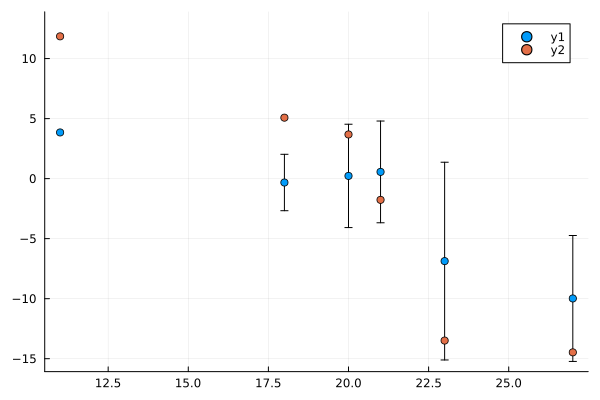

In [79]:
scatter(d_thor[2:end], en_loc_leaf, yerr = st_loc_leaf)
scatter!(reverse(d_thor[2:end]), en_thor)

## Map DCA energy on fitness

In [161]:
scatter(collect(keys(dF2dE)), collect(values(dF2dE)), label ="",
xlabel = "dF", ylabel = "dE")
savefig("../dF2dEmap_dbd.png")

"/home/leonardo/Documents/dF2dEmap_dbd.png"

In [87]:
scatter(collect(keys(dE2dF)), collect(values(dE2dF)), label ="",
xlabel = "dE", ylabel = "dF")
savefig("../dE2dFmap_dbd.png")

"/home/leonardo/Documents/dE2dFmap_dbd.png"